# Analyse des données

Importation des modules

In [124]:
import pandas as pd  
import numpy as np, pandas as pd, matplotlib as plt
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import spearmanr, chi2_contingency
from scipy.stats.contingency import association
from scipy.stats import mannwhitneyu, norm
import chardet
import unicodedata



## Importation des bases de données

In [125]:

base_finale= pd.read_csv("base_finale.csv", delimiter=",", low_memory=False)

base_f= pd.read_csv("base_f.csv", delimiter=",", low_memory=False)

### Analyse de la base

In [126]:
base_finale.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 126073 entries, 0 to 126072
Data columns (total 40 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   Unnamed: 0   126073 non-null  int64  
 1   Num_Acc      126073 non-null  int64  
 2   id_vehicule  126073 non-null  object 
 3   num_veh      126073 non-null  object 
 4   place        126073 non-null  int64  
 5   catu         126073 non-null  int64  
 6   grav         126073 non-null  int64  
 7   sexe         126073 non-null  int64  
 8   an_nais      126073 non-null  float64
 9   trajet       126073 non-null  object 
 10  secu1        126073 non-null  object 
 11  secu2        126073 non-null  object 
 12  secu3        126073 non-null  object 
 13  locp         126073 non-null  object 
 14  actp         126073 non-null  object 
 15  etatp        126073 non-null  int64  
 16  senc         126073 non-null  object 
 17  catv         126073 non-null  object 
 18  obs          126073 non-

### Statistiques descriptives par accident

In [127]:
# Nombre d'usagers (potentiellement victimes ou indemnes) par accident
victimes_par_accident = base_finale.groupby("Num_Acc").size().reset_index(name='nb_usagers')
victimes_par_accident

,Num_Acc,nb_usagers
0,202100000001,2
1,202100000002,2
2,202100000003,2
3,202100000004,2
4,202100000005,1
...,...,...
56514,202100056517,1
56515,202100056518,2
56516,202100056519,1
56517,202100056520,1


Distribution du nombre d'usagers par accident

<Axes: ylabel='Count'>

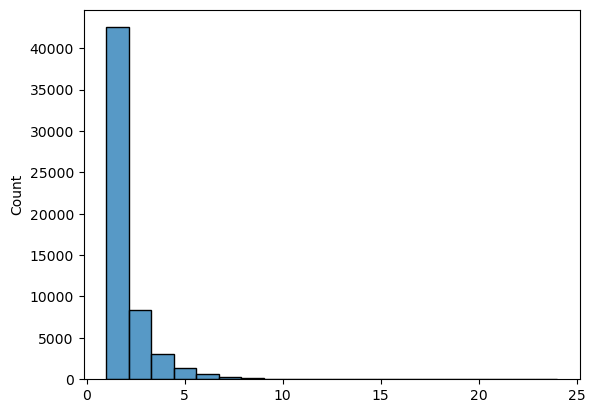

In [128]:
sns.histplot(base_finale.groupby("Num_Acc").size(), bins=20)

Le graphe montre clairement une distribution très asymétrique à droite (skewed right) du nombre d’usagers par accident :
* La majorité des accidents impliquent un seul usager.
* Un nombre décroissant d'accidents implique 2, 3, 4… usagers.
* Quelques cas rares avec plus de 10 usagers (jusqu’à 24 selon l’axe)

Comparons la distribution de la gravité (grav) en fonction du nombre d’usagers par accident.

In [129]:
# Moyenne du nombre d'usagers impliqués par accident
moyenne_usagers = victimes_par_accident['nb_usagers'].mean()
print(f"Nombre moyen d'usagers par accident : {moyenne_usagers:.2f}")


Nombre moyen d'usagers par accident : 2.23


In [130]:
# Pourcentage de chaque niveau de gravité (1: indemne, 2: tué, 3: blessé hospitalisé, 4: blessé léger)
gravite_proportions = base_finale['grav'].value_counts(normalize=True).sort_index() * 100
print("Répartition (%) des gravités :\n", gravite_proportions)


Répartition (%) des gravités :
 grav
1    41.322884
2     2.552489
3    15.134882
4    40.989744
Name: proportion, dtype: float64


### Analyse croisée usager–gravité

Cartégorisons les groupes

In [131]:
def categoriser_nb_usagers(n):
    if n == 1:
        return "1 usager"
    elif n <= 3:
        return "2-3 usagers"
    elif n <= 5:
        return "4-5 usagers"
    else:
        return "6+ usagers"

base_finale["cat_nb_usagers"] = base_finale["nb_usagers"].apply(categoriser_nb_usagers)


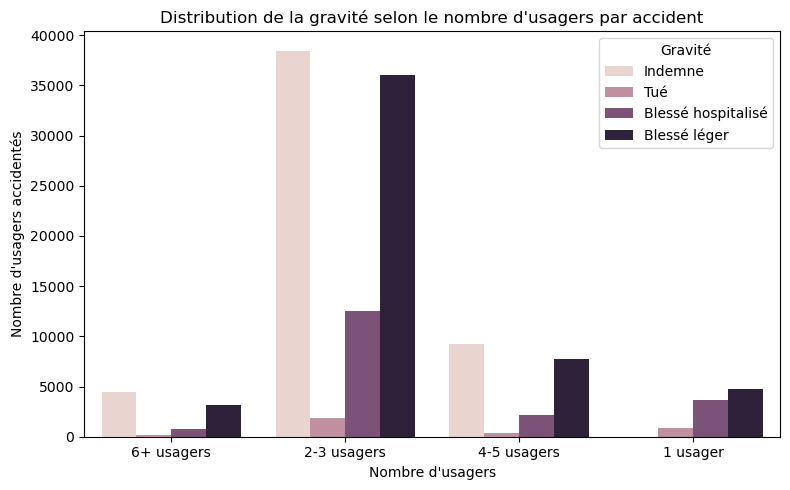

In [132]:
plt.figure(figsize=(8, 5))
sns.countplot(data=base_finale, x="cat_nb_usagers", hue="grav")
plt.title("Distribution de la gravité selon le nombre d'usagers par accident")
plt.xlabel("Nombre d'usagers")
plt.ylabel("Nombre d'usagers accidentés")
plt.legend(title="Gravité", labels=["Indemne", "Tué", "Blessé hospitalisé", "Blessé léger"])
plt.tight_layout()
plt.show()


* Les accidents avec 2-3 usagers représentent la majorité des cas et contiennent le plus de blessés légers et hospitalisés.
* Les accidents avec 1 usager, Bien présents mais avec peu de blessés graves comparativement au premier. Ces accidents sont souvent moins graves en moyenne.
* Accidents avec ≥6 usagers : Rares mais avec une proportion non négligeable de blessés hospitalisés.

In [133]:
# Analysons le taux de gravité par catégorie
base_finale["victime_grave"] = base_finale["grav"].isin([2, 3])  # 2 = tué, 3 = blessé hospitalisé
taux_gravite = base_finale.groupby("cat_nb_usagers")["victime_grave"].mean()


In [134]:
## Représentation en pourcentage pour chaque catégorie de gravité
distribution = base_finale.groupby(["cat_nb_usagers", "grav"]).size().reset_index(name='count')
distribution_total = distribution.groupby("cat_nb_usagers")["count"].transform('sum')
distribution["pourcentage"] = distribution["count"] / distribution_total * 100


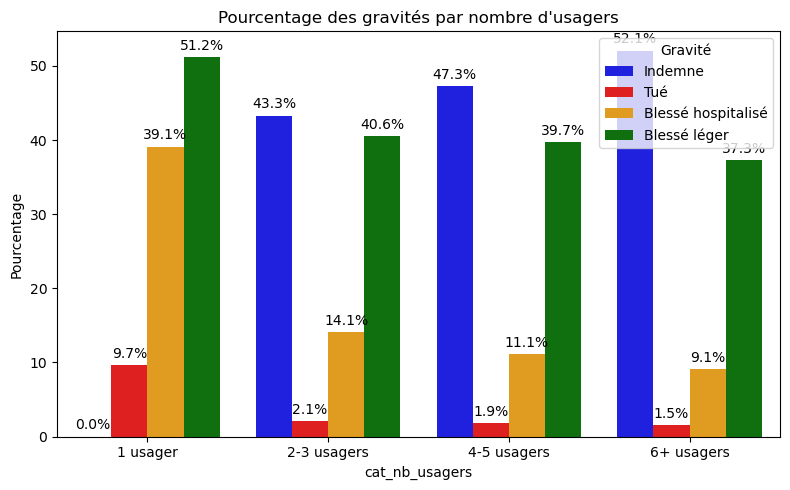

In [135]:
# Création du graphique
# Labelisation de "grav"
distribution["grav_cat"] = distribution["grav"].map({
    1: "Indemne", 2: "Tué", 3: "Blessé hospitalisé", 4: "Blessé léger"})

# Définir la palette couleur avec les libellés
palette = {"Indemne": "blue", "Tué": "red", "Blessé hospitalisé": "orange", "Blessé léger": "green"}

plt.figure(figsize=(8, 5))
ax = sns.barplot(data=distribution, x="cat_nb_usagers", y="pourcentage", hue="grav_cat", palette=palette)

# Ajout des taux sur les barres
for container in ax.containers:
    ax.bar_label(container, fmt="%.1f%%", padding=3)

# Mettre des couleurs sur la légende
handles, labels = ax.get_legend_handles_labels()
plt.legend(handles=handles, labels=["Indemne", "Tué", "Blessé hospitalisé", "Blessé léger"], title="Gravité")

# Personnalisation du graphique
plt.ylabel("Pourcentage")
plt.title("Pourcentage des gravités par nombre d'usagers")
plt.tight_layout()
plt.show()

### Analyse croisée usager–âge-accident

In [136]:
# Analyse de l’âge
base_finale.groupby("cat_nb_usagers")["age"].mean()


cat_nb_usagers
1 usager       38.430403
2-3 usagers    39.308121
4-5 usagers    33.862545
6+ usagers     31.911678
Name: age, dtype: float64

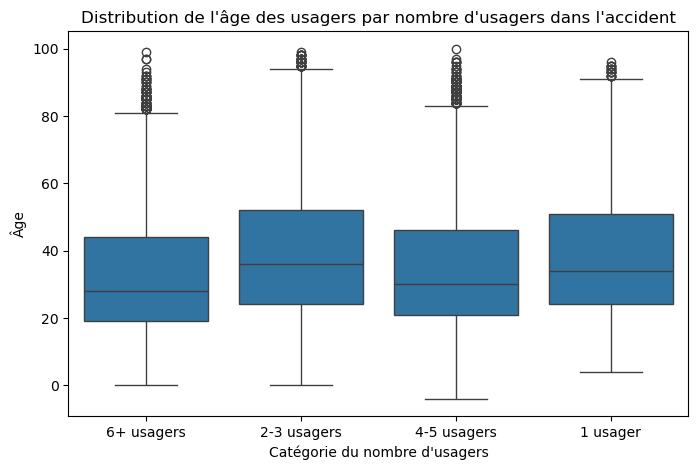

In [137]:
plt.figure(figsize=(8, 5))
sns.boxplot(data=base_finale, x="cat_nb_usagers", y="age")
plt.title("Distribution de l'âge des usagers par nombre d'usagers dans l'accident")
plt.ylabel("Âge")
plt.xlabel("Catégorie du nombre d'usagers")
plt.show()


### Analyse croisée usager–sexe-accident

In [138]:
base_finale["sexe"].value_counts()

sexe
1    86185
2    39888
Name: count, dtype: int64

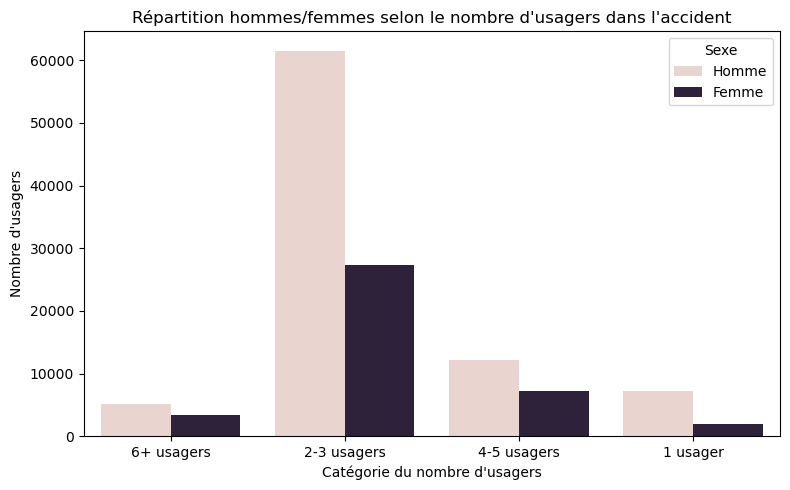

In [139]:
plt.figure(figsize=(8, 5))
sns.countplot(data=base_finale, x="cat_nb_usagers", hue="sexe")
plt.title("Répartition hommes/femmes selon le nombre d'usagers dans l'accident")
plt.xlabel("Catégorie du nombre d'usagers")
plt.ylabel("Nombre d'usagers")
plt.legend(title="Sexe", labels=["Homme", "Femme"])
plt.tight_layout()
plt.show()


### Analyse croisée usager–véhicule

Profil des victimes selon le type de véhicule (catv)

In [140]:
base_finale["catv"].value_counts()

catv
Véhicules légers                        81081
Deux-roues motorisés                    19221
Véhicules légers pro                     8529
Deux-roues non motorisés                 6476
Véhicules professionnels spécialisés     3345
Poids lourds                             3028
Véhicules agricoles / spéciaux           2127
Transport en commun                      1604
Autre                                     526
Aucun                                     136
Name: count, dtype: int64

In [141]:
# Comptage des victimes par type de véhicule
profil_vehicule = base_finale.groupby('catv')['grav'].value_counts().unstack().fillna(0)
profil_vehicule.columns = ['Indemne', 'Tué', 'Blessé hospitalisé', 'Blessé léger']
profil_vehicule = profil_vehicule.astype(int)
print(profil_vehicule.head(10))


                                      Indemne   Tué  Blessé hospitalisé  \
catv                                                                      
Aucun                                      18     7                  29   
Autre                                     214     2                  84   
Deux-roues motorisés                     1585   718                6110   
Deux-roues non motorisés                  481   244                1483   
Poids lourds                             2309   101                 213   
Transport en commun                       925    31                  81   
Véhicules agricoles / spéciaux            457    44                 291   
Véhicules légers                        40343  1832                9447   
Véhicules légers pro                     5377   175                 694   
Véhicules professionnels spécialisés      388    64                 649   

                                      Blessé léger  
catv                                          

## Analyse des données par catégorie de véhicule

L’analyse des données montre clairement que les véhicules légers représentent la majorité écrasante des victimes, toutes catégories de gravité confondues. Avec plus de 40 000 personnes indemnes et près de 13 000 blessés (hospitalisés et légers), ce groupe concentre la majorité des accidents. Leur prévalence s’explique naturellement par leur large diffusion sur les routes.
Les véhicules légers professionnels forment un second groupe significatif avec plusieurs milliers d’usagers indemnes et blessés, bien que leur nombre de tués soit relativement faible comparé à celui des véhicules légers classiques. Ce constat pourrait refléter un usage professionnel plus contrôlé ou des conditions de conduite différentes.
Les poids lourds, bien que moins nombreux en termes de victimes, affichent un profil plus stable avec un nombre relativement faible de tués et de blessés. Cela peut être lié à leur mode d’utilisation spécifique, aux infrastructures ou à la réglementation plus stricte qui encadre leur circulation.
Un point particulièrement important ressort des données concernant les deux-roues motorisés. Ce groupe, bien que représentant une part moindre du total, présente un nombre élevé de tués et de blessés hospitalisés. La vulnérabilité des conducteurs de motos et scooters est ainsi clairement mise en lumière, soulignant le danger inhérent à ce mode de déplacement, souvent associé à une moindre protection physique.
De même, les deux-roues non motorisés (vélos, VAE) présentent une proportion importante de blessés, avec un nombre notable de blessés légers et hospitalisés, bien que le nombre de tués soit moindre. Leur exposition à des risques élevés malgré l’absence de motorisation souligne l’importance de mesures de sécurité adaptées.
Les données relatives au transport en commun montrent une fréquence relativement faible d’accidents graves, ce qui témoigne de la sécurité relative offerte par ces modes de transport. Ces véhicules protègent mieux leurs usagers, ce qui se traduit par un nombre plus élevé d’indemnes et un faible nombre de tués.
Enfin, les catégories dites "Autre", "Aucun" ou "NR" (non renseigné) doivent être interprétées avec prudence car elles peuvent contenir des erreurs ou des cas atypiques qui peuvent biaiser légèrement les résultats.

## Conclusion

Cette analyse souligne la nécessité de concentrer les efforts de prévention et de sécurité sur les usagers les plus vulnérables et exposés, notamment les conducteurs de deux-roues motorisés et non motorisés, qui subissent un nombre disproportionné de blessures graves et de décès. La prédominance des véhicules légers dans le nombre total de victimes justifie également un renforcement des campagnes de sensibilisation et des mesures de sécurité pour cette catégorie.
Par ailleurs, la faible gravité relative des accidents impliquant les poids lourds et les transports en commun confirme l’efficacité des normes et réglementations spécifiques qui encadrent leur circulation, ainsi que la protection accrue offerte à leurs occupants.

En résumé, cette étude met en évidence des disparités importantes selon le type de véhicule, orientant les priorités vers la protection renforcée des deux-roues et la prévention ciblée auprès des conducteurs de véhicules légers, afin d’améliorer globalement la sécurité routière.


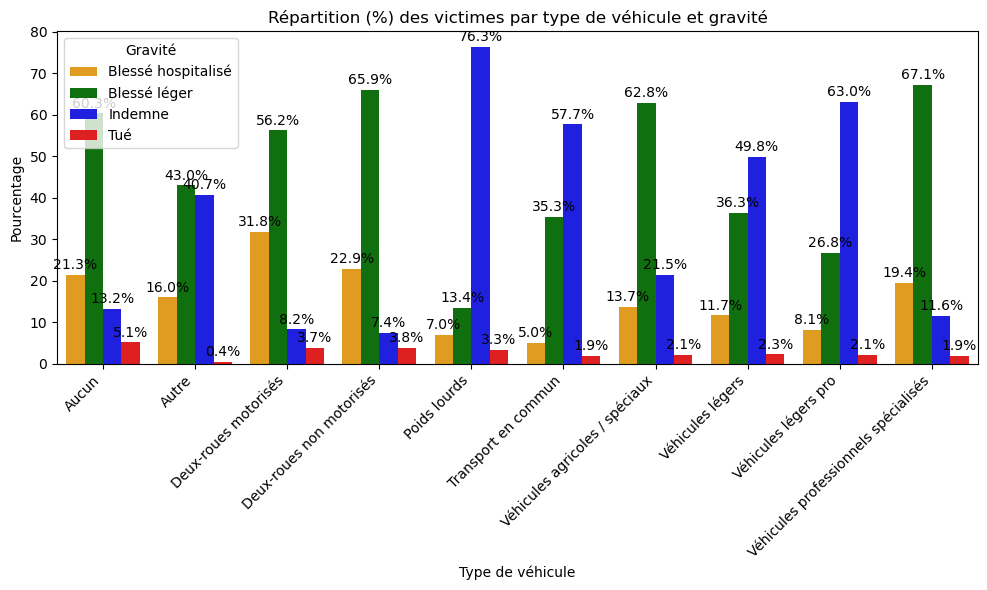

In [142]:
# labels de gravité
base_finale["grav_cat"] = base_finale["grav"].map({1: "Indemne",2: "Tué",3: "Blessé hospitalisé",4: "Blessé léger"})
# Calcul de la distribution en pourcentage par type de véhicule
distribution = base_finale.groupby(['catv', 'grav_cat']).size().reset_index(name='count')
distribution['total'] = distribution.groupby('catv')['count'].transform('sum')
distribution['pourcentage'] = (distribution['count'] / distribution['total']) * 100
# Palette de couleurs personnalisée
palette = {"Indemne": "blue","Tué": "red","Blessé hospitalisé": "orange","Blessé léger": "green"}
# Création du graphique à barres
plt.figure(figsize=(10, 6))
ax = sns.barplot(data=distribution, x="catv", y="pourcentage", hue="grav_cat", palette=palette)
# Affichage des pourcentages sur les barres
for container in ax.containers:
    ax.bar_label(container, fmt="%.1f%%", padding=2)
# Légende claire
handles, labels = ax.get_legend_handles_labels()
plt.legend(handles=handles, title="Gravité")

plt.title("Répartition (%) des victimes par type de véhicule et gravité")
plt.xlabel("Type de véhicule")
plt.ylabel("Pourcentage")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


### Gravité selon le sexe et l'âge

##### Définissons les labels

In [143]:
# Définition des labels de gravité
labels_grav = {1: "Indemne", 2: "Tué", 3: "Blessé hospitalisé", 4: "Blessé léger"}

# Labels pour les conditions de lumière
labels_lum = {1: "Plein jour",2: "Crépuscule ou aube",3: "Nuit sans éclairage public",4: "Nuit avec éclairage public non allumé",
    5: "Nuit avec éclairage public allumé"}

# Labels pour les conditions météo
labels_atm = {1: "Normale",2: "Pluie légère",3: "Pluie forte",4: "Neige - grêle",5: "Brouillard - fumée",
    6: "Vent fort - tempête",7: "Temps éblouissant",8: "Temps couvert",9: "Autre"
}

# Labels pour les équipements de sécurité
labels_secu = {
    0: "Aucun équipement",1: "Ceinture",2: "Casque",3: "Dispositif enfants", 4: "Gilet réfléchissant",5: "Airbag",6: "Gants",7: "Gants + Airbag",
     8: "Non renseigné", 9: "Autre"
}



Gravité par Sexe (%):
                     Masculin  Féminin
grav                                 
Indemne                71.32    28.68
Tué                    78.31    21.69
Blessé hospitalisé     71.47    28.53
Blessé léger           63.61    36.39


<Figure size 800x500 with 0 Axes>

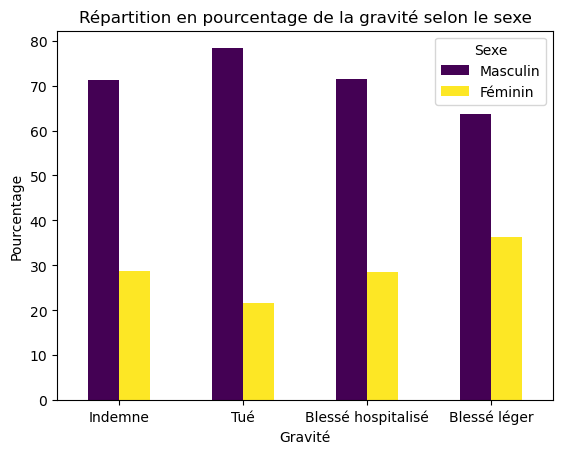

In [144]:

# Création du tableau croisé entre gravité et sexe (en %)
cross_grav_sexe = pd.crosstab(base_finale['grav'], base_finale['sexe'], normalize='index') * 100
cross_grav_sexe.columns = ['Masculin', 'Féminin']

# Ajout des labels de gravité
cross_grav_sexe.index = cross_grav_sexe.index.map(labels_grav)

print("Gravité par Sexe (%):\n", cross_grav_sexe.round(2))

# Création du graphique avec Seaborn
plt.figure(figsize=(8, 5))
cross_grav_sexe.plot(kind='bar', stacked=False, colormap='viridis')

plt.title("Répartition en pourcentage de la gravité selon le sexe")
plt.xlabel("Gravité")
plt.ylabel("Pourcentage")
plt.legend(title="Sexe")
plt.xticks(rotation=0)  # Pour une meilleure lisibilité des labels

plt.show()


Âge moyen par gravité :
                  grav    age
0             Indemne  39.28
1                 Tué  46.42
2  Blessé hospitalisé  39.46
3        Blessé léger  35.41


C:\Users\SCD UM\AppData\Local\Temp\ipykernel_14508\436028006.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=age_moyen_par_gravite, x='grav', y='age', palette='viridis')


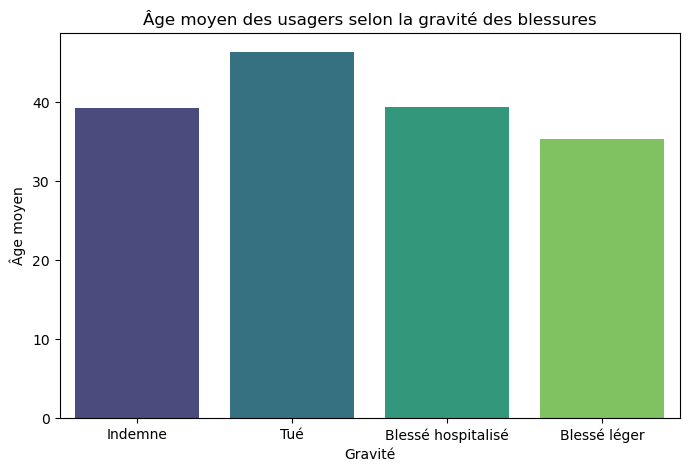

In [145]:

# Calcul de l'âge moyen par gravité
age_moyen_par_gravite = base_finale.groupby('grav')['age'].mean().reset_index()

age_moyen_par_gravite['grav'] = age_moyen_par_gravite['grav'].map(labels_grav)

print("Âge moyen par gravité :\n", age_moyen_par_gravite.round(2))

# Création du graphique
plt.figure(figsize=(8, 5))
sns.barplot(data=age_moyen_par_gravite, x='grav', y='age', palette='viridis')

plt.title("Âge moyen des usagers selon la gravité des blessures")
plt.xlabel("Gravité")
plt.ylabel("Âge moyen")
plt.xticks(rotation=0)  # Meilleure lisibilité des catégories
plt.show()


C:\Users\SCD UM\AppData\Local\Temp\ipykernel_14508\2060480.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=accidents_par_heure.index, y=accidents_par_heure.values, palette="viridis")


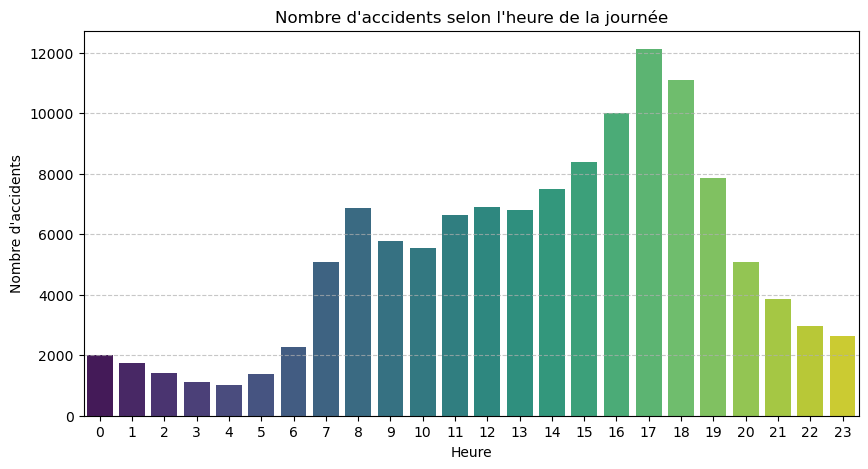

In [146]:
# Extraire l'heure uniquement si hrmn est bien formatée (ex: '1530' → 15)
base_finale['heure'] = base_finale['hrmn'].astype(str).str.zfill(4).str[:2].astype(int)

# Comptage des accidents par heure
accidents_par_heure = base_finale['heure'].value_counts().sort_index()
#print("Nombre d'accidents par heure :\n", accidents_par_heure)

# Création du graphique
plt.figure(figsize=(10, 5))
sns.barplot(x=accidents_par_heure.index, y=accidents_par_heure.values, palette="viridis")

plt.title("Nombre d'accidents selon l'heure de la journée")
plt.xlabel("Heure")
plt.ylabel("Nombre d'accidents")
plt.xticks(rotation=0)  # Garde les heures lisibles
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.show()


C:\Users\SCD UM\AppData\Local\Temp\ipykernel_14508\2118869569.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=accidents_par_jour.index, y=accidents_par_jour.values, palette="Blues")


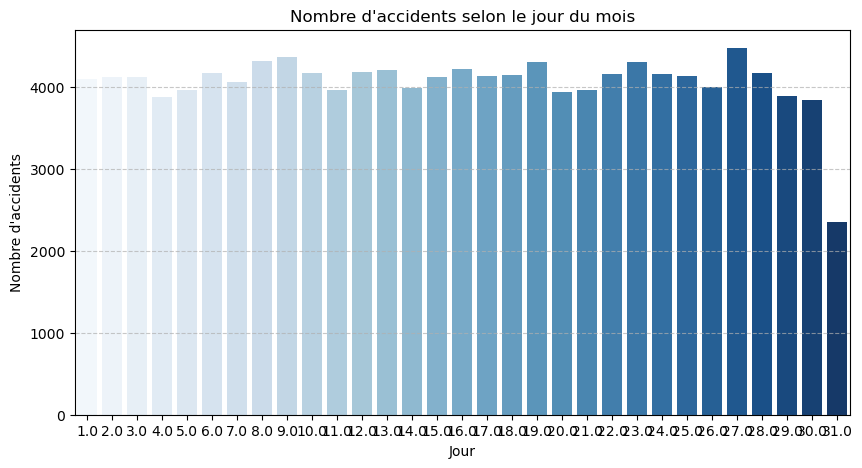

In [147]:
# Comptage des accidents par jour
accidents_par_jour = base_finale['jour'].value_counts().sort_index()
# Graphique des accidents par jour
plt.figure(figsize=(10, 5))
sns.barplot(x=accidents_par_jour.index, y=accidents_par_jour.values, palette="Blues")
plt.title("Nombre d'accidents selon le jour du mois")
plt.xlabel("Jour")
plt.ylabel("Nombre d'accidents")
plt.xticks(rotation=0)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


C:\Users\SCD UM\AppData\Local\Temp\ipykernel_14508\2025279169.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=accidents_par_mois.index, y=accidents_par_mois.values, palette="Reds")


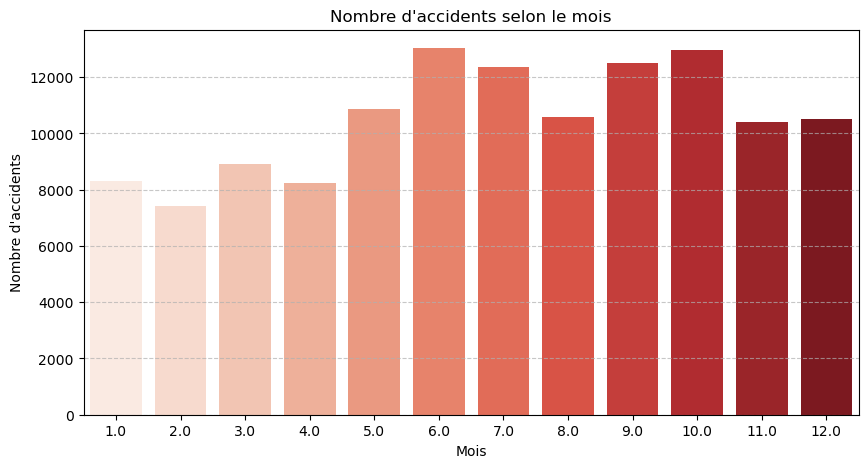

In [148]:
# Comptage des accidents par mois
accidents_par_mois = base_finale['mois'].value_counts().sort_index()
# Graphique des accidents par mois
plt.figure(figsize=(10, 5))
sns.barplot(x=accidents_par_mois.index, y=accidents_par_mois.values, palette="Reds")
plt.title("Nombre d'accidents selon le mois")
plt.xlabel("Mois")
plt.ylabel("Nombre d'accidents")
plt.xticks(rotation=0)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

### Distribution spatiale : par commune (com) et département (dep)

C:\Users\SCD UM\AppData\Local\Temp\ipykernel_14508\3423330474.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=accidents_par_commune.index, y=accidents_par_commune.values, palette="Blues")


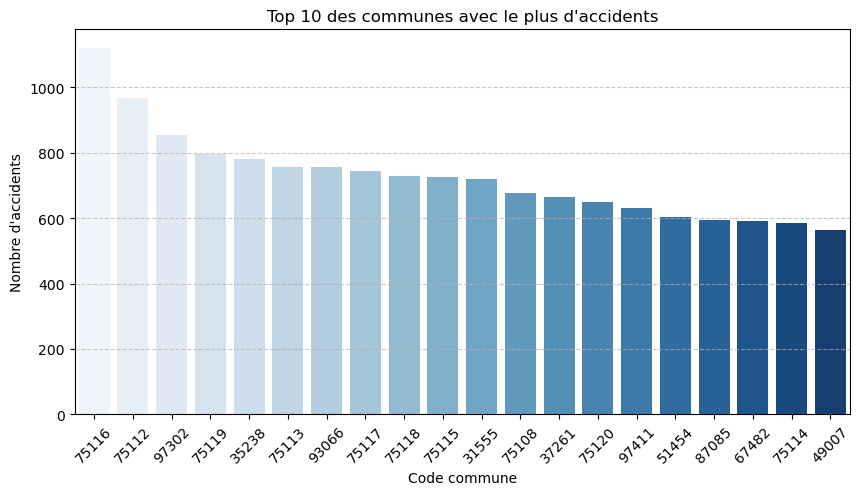

In [149]:
# Comptage des accidents par commune
accidents_par_commune = base_finale['com'].value_counts().head(20)
#print("Top 10 des communes avec le plus d'accidents :\n", accidents_par_commune)

# Graphique des accidents par commune
plt.figure(figsize=(10, 5))
sns.barplot(x=accidents_par_commune.index, y=accidents_par_commune.values, palette="Blues")
plt.title("Top 10 des communes avec le plus d'accidents")
plt.xlabel("Code commune")
plt.ylabel("Nombre d'accidents")
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


C:\Users\SCD UM\AppData\Local\Temp\ipykernel_14508\10050846.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=accidents_par_departement.index, y=accidents_par_departement.values, palette="Reds")


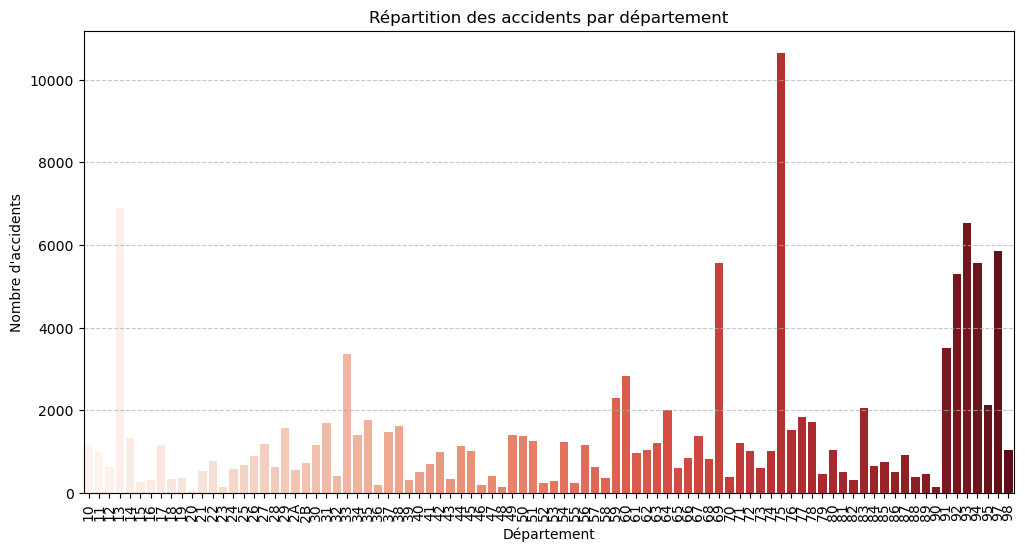

In [150]:
# Comptage des accidents par département
accidents_par_departement = base_finale['dep'].value_counts().sort_index()
#print("Répartition des accidents par département :\n", accidents_par_departement)

# Graphique des accidents par département
plt.figure(figsize=(12, 6))
sns.barplot(x=accidents_par_departement.index, y=accidents_par_departement.values, palette="Reds")
plt.title("Répartition des accidents par département")
plt.xlabel("Département")
plt.ylabel("Nombre d'accidents")
plt.xticks(rotation=90)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


### Croisement entre gravité et catégorie d'usager

Gravité par Catégorie d’usager (%):
                     Conducteur  Passager  Piéton
grav                                            
Indemne                  83.59     15.90    0.51
Tué                      71.16     14.61   14.23
Blessé hospitalisé       69.86     16.56   13.58
Blessé léger             67.80     20.28   11.92


<Figure size 800x500 with 0 Axes>

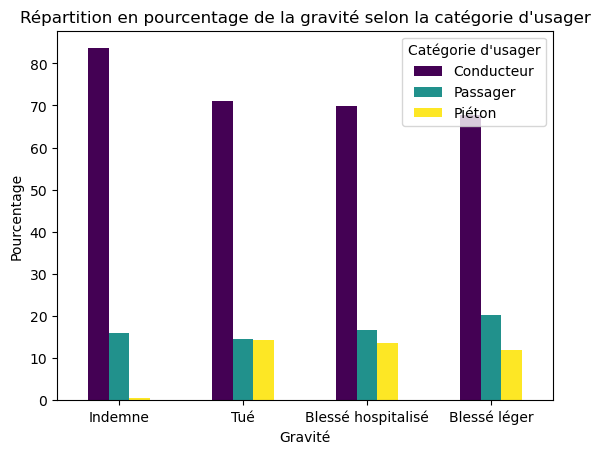

In [151]:

# Création du tableau croisé entre gravité et catégorie d'usager (en %)
cross_grav_catu = pd.crosstab(base_finale['grav'], base_finale['catu'], normalize='index') * 100
cross_grav_catu.columns = ['Conducteur', 'Passager', 'Piéton']
cross_grav_catu.index = cross_grav_catu.index.map(labels_grav)

print("Gravité par Catégorie d’usager (%):\n", cross_grav_catu.round(2))

# Création du graphique en barres empilées
plt.figure(figsize=(8, 5))
cross_grav_catu.plot(kind='bar', stacked=False, colormap='viridis')

plt.title("Répartition en pourcentage de la gravité selon la catégorie d'usager")
plt.xlabel("Gravité")
plt.ylabel("Pourcentage")
plt.legend(title="Catégorie d'usager")
plt.xticks(rotation=0)  # Pour une meilleure lisibilité des labels

plt.show()


### Gravité × Type de véhicule (catv)

Gravité par Type de véhicule (%):
 catv                Aucun  Autre  Deux-roues motorisés  \
grav                                                     
Indemne              0.03   0.41                  3.04   
Tué                  0.22   0.06                 22.31   
Blessé hospitalisé   0.15   0.44                 32.02   
Blessé léger         0.16   0.44                 20.91   

catv                Deux-roues non motorisés  Poids lourds  \
grav                                                         
Indemne                                 0.92          4.43   
Tué                                     7.58          3.14   
Blessé hospitalisé                      7.77          1.12   
Blessé léger                            8.26          0.78   

catv                Transport en commun  Véhicules agricoles / spéciaux  \
grav                                                                      
Indemne                            1.78                            0.88   
Tué               

<Figure size 2000x1500 with 0 Axes>

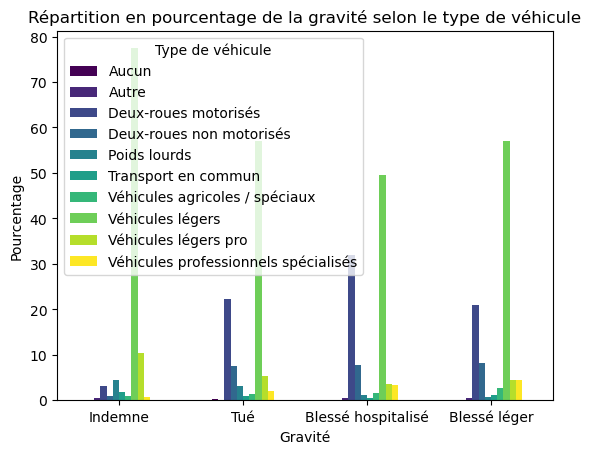

In [152]:
# Création du tableau croisé entre gravité et type de véhicule (en %)
cross_grav_catv = pd.crosstab(base_finale['grav'], base_finale['catv'], normalize='index') * 100
cross_grav_catv.index = cross_grav_catv.index.map(labels_grav)

print("Gravité par Type de véhicule (%):\n", cross_grav_catv.round(2))


# Création du graphique en barres empilées avec les couleurs définies
plt.figure(figsize=(20, 15))
cross_grav_catv.plot(kind='bar', stacked=False, colormap='viridis')

plt.title("Répartition en pourcentage de la gravité selon le type de véhicule")
plt.xlabel("Gravité")
plt.ylabel("Pourcentage")
plt.legend(title="Type de véhicule")
plt.xticks(rotation=0)  # Amélioration de la lisibilité des labels

plt.show()


Répartition de la gravité selon le type de véhicule :
                                       Indemne   Tué  Blessé hospitalisé  \
catv                                                                      
Aucun                                   13.24  5.15               21.32   
Autre                                   40.68  0.38               15.97   
Deux-roues motorisés                     8.25  3.74               31.79   
Deux-roues non motorisés                 7.43  3.77               22.90   
Poids lourds                            76.25  3.34                7.03   
Transport en commun                     57.67  1.93                5.05   
Véhicules agricoles / spéciaux          21.49  2.07               13.68   
Véhicules légers                        49.76  2.26               11.65   
Véhicules légers pro                    63.04  2.05                8.14   
Véhicules professionnels spécialisés    11.60  1.91               19.40   

                                      Blessé

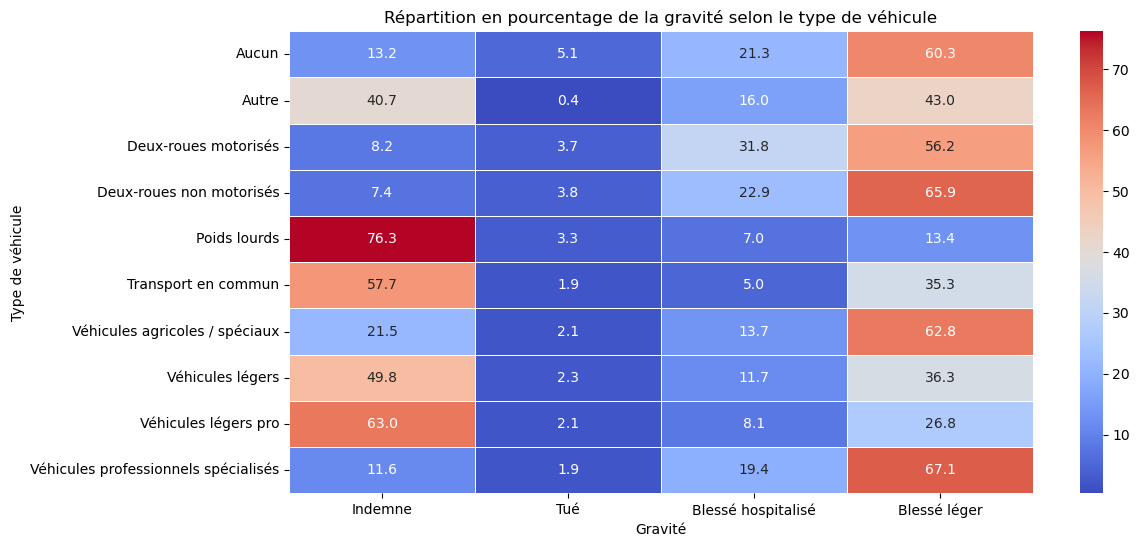

In [153]:
# Table croisée gravité × type de véhicule
gravite_catv = pd.crosstab(base_finale['catv'], base_finale['grav'], normalize='index') * 100
gravite_catv.columns = ["Indemne", "Tué", "Blessé hospitalisé", "Blessé léger"]

print("Répartition de la gravité selon le type de véhicule :\n", gravite_catv.round(2))

# Création d'une heatmap
plt.figure(figsize=(12, 6))
sns.heatmap(gravite_catv, annot=True, fmt=".1f", cmap="coolwarm", linewidths=0.5)

plt.title("Répartition en pourcentage de la gravité selon le type de véhicule")
plt.xlabel("Gravité")
plt.ylabel("Type de véhicule")
plt.xticks(rotation=0)
plt.yticks(rotation=0)
plt.show()


### Gravité × Conditions de lumière (lum) et météo (atm)

Gravité * Conditions de lumière (%):
                     Plein jour  Crépuscule ou aube  \
grav                                                 
Indemne                  72.40                6.33   
Tué                      58.89                7.43   
Blessé hospitalisé       67.59                7.48   
Blessé léger             68.69                6.29   

                    Nuit sans éclairage public  \
grav                                             
Indemne                                   7.32   
Tué                                      22.72   
Blessé hospitalisé                       13.12   
Blessé léger                              8.45   

                    Nuit avec éclairage public non allumé  \
grav                                                        
Indemne                                              0.70   
Tué                                                  1.18   
Blessé hospitalisé                                   0.77   
Blessé léger                   

<Figure size 1000x600 with 0 Axes>

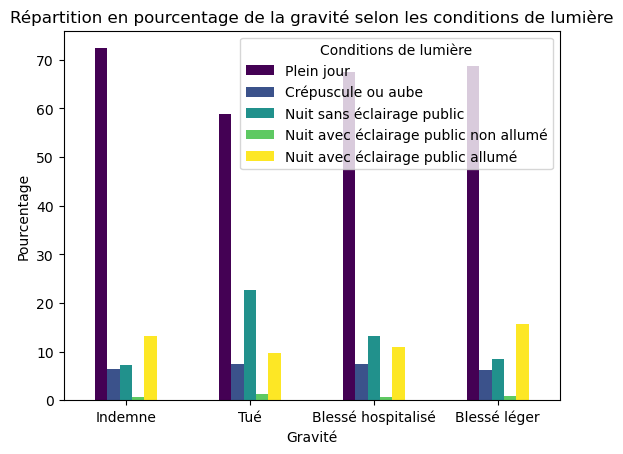

In [154]:
# Gravité × Conditions de lumière
cross_grav_lum = pd.crosstab(base_finale['grav'], base_finale['lum'], normalize='index') * 100
cross_grav_lum.index = cross_grav_lum.index.map(labels_grav)
cross_grav_lum.columns = [labels_lum.get(col, f"Inconnu ({col})") for col in cross_grav_lum.columns]

print("Gravité * Conditions de lumière (%):\n", cross_grav_lum.round(2))

# Graphique en barres empilées pour la lumière
plt.figure(figsize=(10, 6))
cross_grav_lum.plot(kind='bar', stacked=False, colormap='viridis')

plt.title("Répartition en pourcentage de la gravité selon les conditions de lumière")
plt.xlabel("Gravité")
plt.ylabel("Pourcentage")
plt.legend(title="Conditions de lumière")
plt.xticks(rotation=0)

plt.show()

Gravité * Conditions météo (%):
                     Normale  Pluie légère  Pluie forte  Neige - grêle  \
grav                                                                    
Indemne               80.11         10.41         2.08           0.52   
Tué                   77.78          9.38         2.05           0.44   
Blessé hospitalisé    80.55          8.69         2.05           0.54   
Blessé léger          79.11         11.59         2.06           0.47   

                    Brouillard - fumée  Vent fort - tempête  \
grav                                                          
Indemne                           0.58                 0.17   
Tué                               1.86                 0.40   
Blessé hospitalisé                1.00                 0.35   
Blessé léger                      0.64                 0.16   

                    Temps éblouissant  Temps couvert  Autre  
grav                                                         
Indemne                  

<Figure size 1000x600 with 0 Axes>

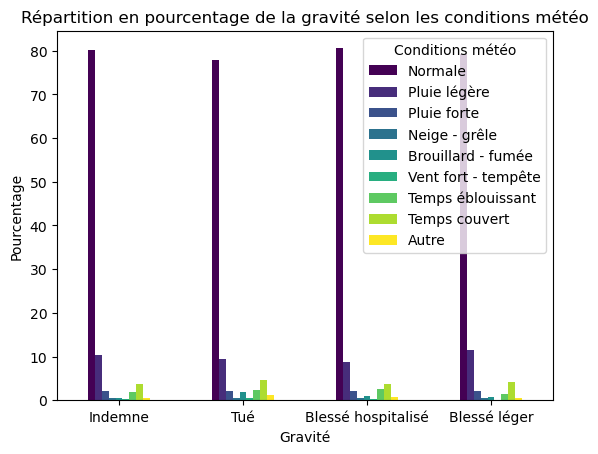

In [155]:
# Gravité × Conditions météo
cross_grav_atm = pd.crosstab(base_finale['grav'], base_finale['atm'], normalize='index') * 100
cross_grav_atm.index = cross_grav_atm.index.map(labels_grav)
cross_grav_atm.columns = [labels_atm.get(col, f"{col}") for col in cross_grav_atm.columns]

print("Gravité * Conditions météo (%):\n", cross_grav_atm.round(2))

# Graphique en barres empilées pour la météo
plt.figure(figsize=(10, 6))
cross_grav_atm.plot(kind='bar', stacked=False, colormap='viridis')

plt.title("Répartition en pourcentage de la gravité selon les conditions météo")
plt.xlabel("Gravité")
plt.ylabel("Pourcentage")
plt.legend(title="Conditions météo")
plt.xticks(rotation=0)

plt.show()



### Gravité × Port des équipements de sécurité

Gravité et Équipement 1 (%):
                     Airbag  Aucun  Autre  Casque  Ceinture  \
grav                                                         
Indemne               0.01   1.49   0.09    4.03     84.49   
Tué                   0.06  25.79   0.19   25.73     34.93   
Blessé hospitalisé    0.05  18.89   0.16   36.77     33.04   
Blessé léger          0.01  12.79   0.05   27.09     47.07   

                    Dispositif enfants  Gants  Gants + Airbag  \
grav                                                            
Indemne                           0.79   0.02            0.00   
Tué                               0.40   0.34            0.00   
Blessé hospitalisé                0.31   0.38            0.00   
Blessé léger                      0.65   0.04            0.01   

                    Gilet réfléchissant  Non renseigné  
grav                                                    
Indemne                            0.02           9.06  
Tué                                

<Figure size 1500x800 with 0 Axes>

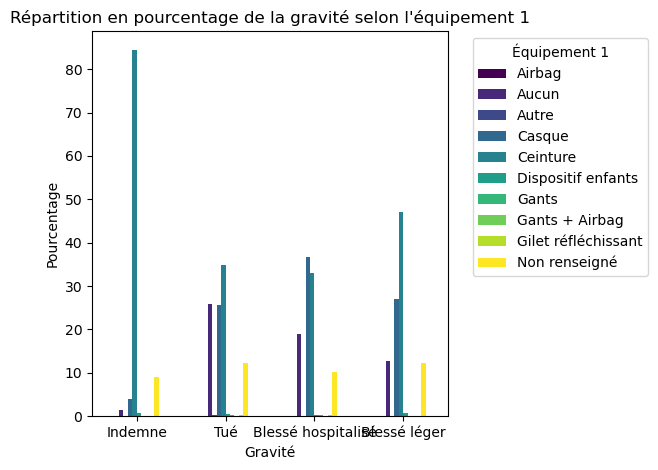

In [156]:

# Création du tableau croisé
cross_grav_secu1 = pd.crosstab(base_finale['grav'], base_finale['secu1'], normalize='index') * 100
cross_grav_secu1.index = cross_grav_secu1.index.map(labels_grav)
cross_grav_secu1.columns = [labels_secu.get(col, f"{col}") for col in cross_grav_secu1.columns]

print("Gravité et Équipement 1 (%):\n", cross_grav_secu1.round(2))

# Graphique
plt.figure(figsize=(15, 8))
cross_grav_secu1.plot(kind='bar', stacked=False, colormap='viridis')
plt.title("Répartition en pourcentage de la gravité selon l'équipement 1")
plt.xlabel("Gravité")
plt.ylabel("Pourcentage")
plt.legend(title="Équipement 1", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()


Gravité selon Équipement 2 (%):
                        -1  Airbag  Aucun  Autre  Casque  Ceinture  \
grav                                                                
Indemne             38.36    1.11  45.88   0.15    0.02      0.26   
Tué                 69.76    0.81  11.06   0.71    0.31      0.12   
Blessé hospitalisé  59.79    1.05  13.27   0.68    0.34      0.17   
Blessé léger        37.43    1.40  37.32   0.23    0.08      0.15   

                    Dispositif enfants  Gants  Gants + Airbag  \
grav                                                            
Indemne                           0.15   2.11            0.05   
Tué                               0.06  12.43            0.19   
Blessé hospitalisé                0.13  18.78            0.25   
Blessé léger                      0.08  12.71            0.12   

                    Gilet réfléchissant  Non renseigné  
grav                                                    
Indemne                            1.49        

<Figure size 1000x600 with 0 Axes>

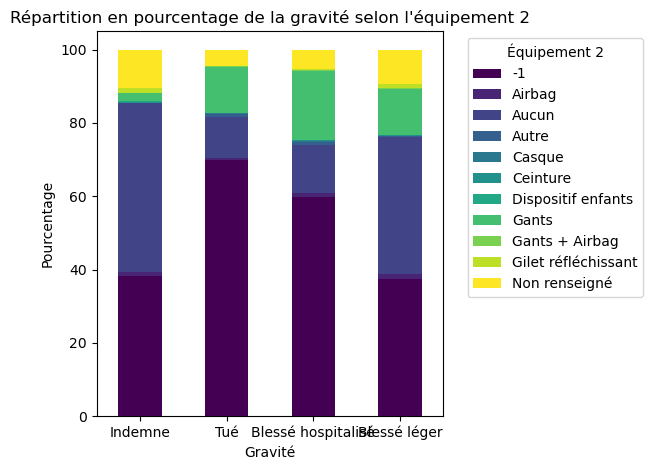

In [157]:
cross_grav_secu2 = pd.crosstab(base_finale['grav'], base_finale['secu2'], normalize='index') * 100
cross_grav_secu2.index = cross_grav_secu2.index.map(labels_grav)
cross_grav_secu2.columns = [labels_secu.get(col, f"{col}") for col in cross_grav_secu2.columns]

print("Gravité selon Équipement 2 (%):\n", cross_grav_secu2.round(2))

plt.figure(figsize=(10, 6))
cross_grav_secu2.plot(kind='bar', stacked=True, colormap='viridis')
plt.title("Répartition en pourcentage de la gravité selon l'équipement 2")
plt.xlabel("Gravité")
plt.ylabel("Pourcentage")
plt.legend(title="Équipement 2", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()


Gravité * Équipement 3 (%):
                        -1  Airbag  Aucun  Autre  Casque  Gants  \
grav                                                             
Indemne             99.66    0.01   0.22   0.08    0.00   0.01   
Tué                 97.20    0.00   0.19   2.33    0.00   0.22   
Blessé hospitalisé  96.50    0.01   0.26   2.89    0.01   0.23   
Blessé léger        99.26    0.00   0.20   0.46    0.00   0.04   

                    Gants + Airbag  Gilet réfléchissant  Non renseigné  
grav                                                                    
Indemne                       0.00                 0.00           0.02  
Tué                           0.00                 0.00           0.06  
Blessé hospitalisé            0.01                 0.06           0.04  
Blessé léger                  0.01                 0.01           0.02  


<Figure size 1000x600 with 0 Axes>

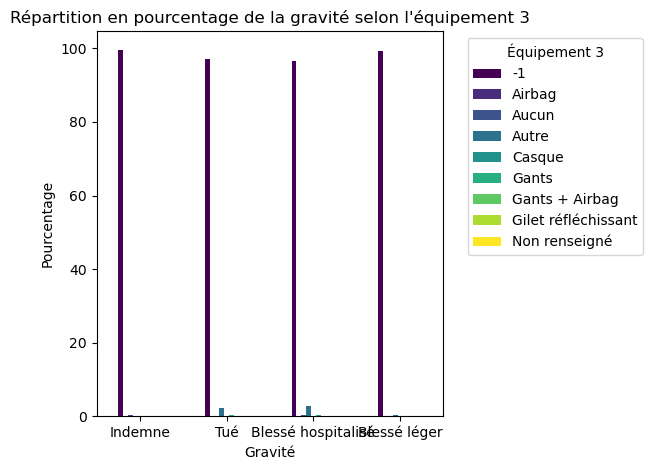

In [158]:
cross_grav_secu3 = pd.crosstab(base_finale['grav'], base_finale['secu3'], normalize='index') * 100
cross_grav_secu3.index = cross_grav_secu3.index.map(labels_grav)
cross_grav_secu3.columns = [labels_secu.get(col, f"{col}") for col in cross_grav_secu3.columns]

print("Gravité * Équipement 3 (%):\n", cross_grav_secu3.round(2))

plt.figure(figsize=(10, 6))
cross_grav_secu3.plot(kind='bar', stacked=False, colormap='viridis')
plt.title("Répartition en pourcentage de la gravité selon l'équipement 3")
plt.xlabel("Gravité")
plt.ylabel("Pourcentage")
plt.legend(title="Équipement 3", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()


In [159]:
base_finale.secu1.value_counts()

secu1
Ceinture               75769
Casque                 23944
Non renseigné          13389
Aucun                  11825
Dispositif enfants       821
Gants                    114
Autre                    109
Gilet réfléchissant       75
Airbag                    24
Gants + Airbag             3
Name: count, dtype: int64

### Les fonctions d'analyse

In [160]:
base_f= base_f.drop(columns=["Unnamed: 0","Num_Acc","id_vehicule","num_veh","an","an_nais","hrmn"])
base_f.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 126073 entries, 0 to 126072
Data columns (total 33 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   place       126073 non-null  int64  
 1   catu        126073 non-null  object 
 2   grav        126073 non-null  int64  
 3   sexe        126073 non-null  object 
 4   trajet      126073 non-null  object 
 5   secu1       126073 non-null  object 
 6   secu2       126073 non-null  object 
 7   secu3       126073 non-null  object 
 8   locp        126073 non-null  object 
 9   actp        126073 non-null  object 
 10  etatp       126073 non-null  object 
 11  senc        126073 non-null  object 
 12  catv        126073 non-null  object 
 13  obs         126073 non-null  object 
 14  obsm        126073 non-null  object 
 15  choc        126073 non-null  object 
 16  manv        126073 non-null  object 
 17  motor       126073 non-null  object 
 18  occutc      1341 non-null    object 
 19  jo

In [161]:
def analyse_univ(df):
   for col in df.columns:
        print(f"Analysons la variable : {col}")
        print("-" * 50)
        
        # Nombre de valeurs manquantes
        missing_values = df[col].isnull().sum()
        print(f"Le nombre de valeurs manquantes de {col}: {missing_values}")
        
        # Calcul du mode
        mode = df[col].mode().iloc[0] if not df[col].mode().empty else "Pas de mode"
        print(f"Le mode de la variable {col} est : {mode}")
        
        # Vérifier si la variable est quantitative
        if pd.api.types.is_numeric_dtype(df[col]):
            print(df[col].describe())
            plt.figure(figsize=(6, 4))
            sns.histplot(df[col], kde=True, bins=20, color="skyblue")
            plt.title(f"Histogramme de {col}")
            plt.xlabel(col)
            plt.ylabel("Fréquence")
            plt.show()
        
        # Vérifier si la variable est qualitative
        else:
            print(df[col].value_counts())
            unique_values = df[col].nunique()
            
            # Diagramme circulaire pour les variables avec deux modalités
            if unique_values == 2:
                plt.figure(figsize=(6, 6))
                df[col].value_counts().plot.pie(autopct='%1.1f%%', colors=["lightblue", "lightgreen"])
                plt.title(f"Diagramme circulaire de {col}")
                plt.ylabel("")  # Supprimer le label inutile
                plt.show()
            
            # Diagramme en barres pour les autres variables qualitatives
            else:
                plt.figure(figsize=(6, 4))
                sns.countplot(x=df[col], order=df[col].value_counts().index, palette="viridis")
                plt.title(f"Diagramme en barres de {col}")
                plt.xlabel(col)
                plt.ylabel("Nombre d'occurrences")
                plt.xticks(rotation=45)
                plt.show()                     

Analysons la variable : place
--------------------------------------------------
Le nombre de valeurs manquantes de place: 0
Le mode de la variable place est : 1
count    126073.000000
mean          2.060045
std           2.550843
min           1.000000
25%           1.000000
50%           1.000000
75%           2.000000
max          10.000000
Name: place, dtype: float64


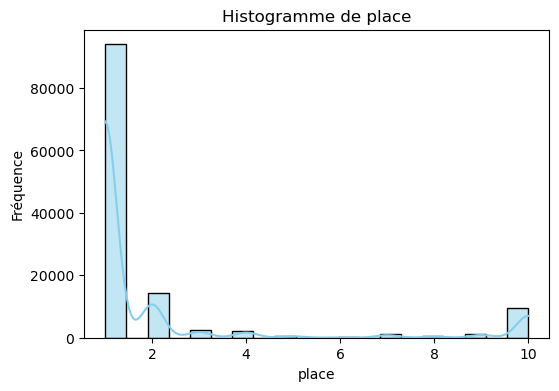

Analysons la variable : catu
--------------------------------------------------
Le nombre de valeurs manquantes de catu: 0
Le mode de la variable catu est : Conducteur
catu
Conducteur    94204
Passager      22398
Piéton         9471
Name: count, dtype: int64


C:\Users\SCD UM\AppData\Local\Temp\ipykernel_14508\1584820988.py:40: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=df[col], order=df[col].value_counts().index, palette="viridis")


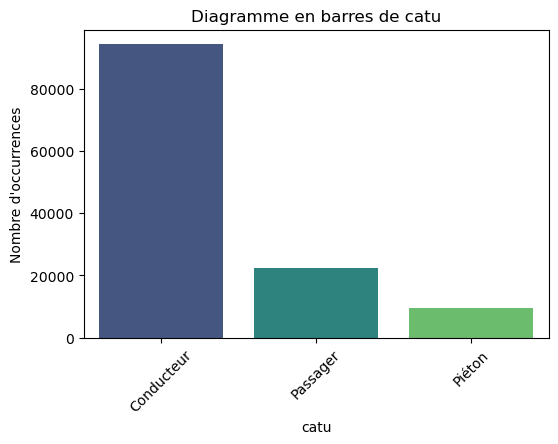

Analysons la variable : grav
--------------------------------------------------
Le nombre de valeurs manquantes de grav: 0
Le mode de la variable grav est : 1
count    126073.000000
mean          2.557915
std           1.375832
min           1.000000
25%           1.000000
50%           3.000000
75%           4.000000
max           4.000000
Name: grav, dtype: float64


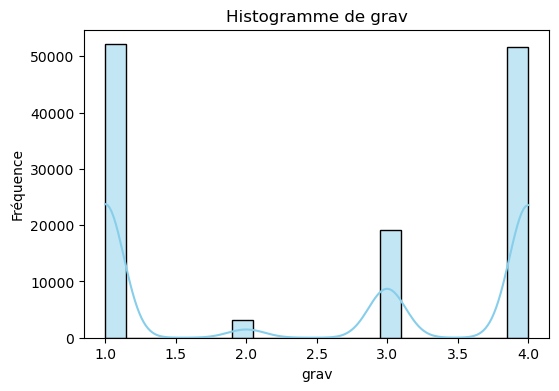

Analysons la variable : sexe
--------------------------------------------------
Le nombre de valeurs manquantes de sexe: 0
Le mode de la variable sexe est : Homme
sexe
Homme    86185
Femme    39888
Name: count, dtype: int64


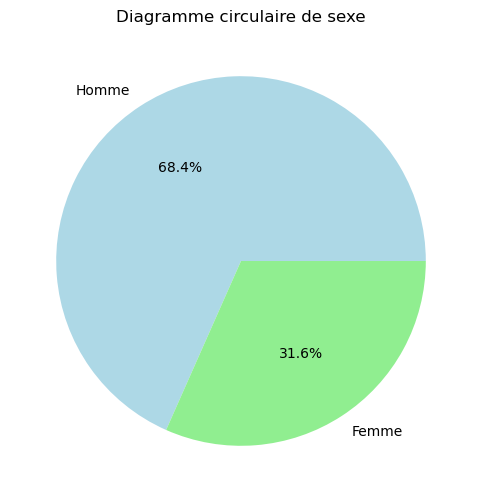

Analysons la variable : trajet
--------------------------------------------------
Le nombre de valeurs manquantes de trajet: 0
Le mode de la variable trajet est : Promenade-loisirs
trajet
Promenade-loisirs              45627
Aucun                          32540
Domicile-travail               17337
Utilisation professionnelle    12181
Autre                          11026
Courses-achats                  4531
Domicile-école                  2831
Name: count, dtype: int64


C:\Users\SCD UM\AppData\Local\Temp\ipykernel_14508\1584820988.py:40: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=df[col], order=df[col].value_counts().index, palette="viridis")


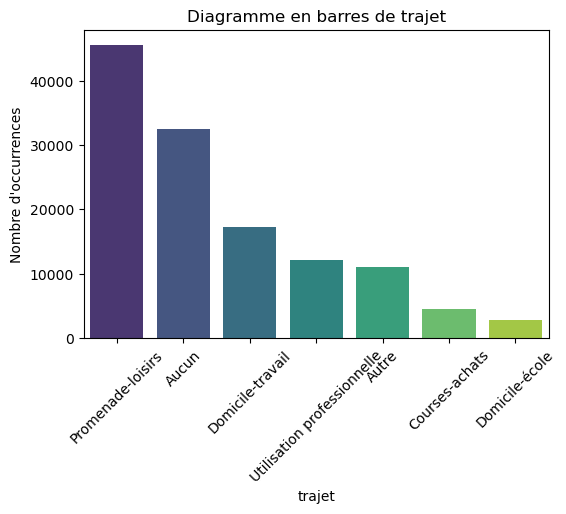

Analysons la variable : secu1
--------------------------------------------------
Le nombre de valeurs manquantes de secu1: 0
Le mode de la variable secu1 est : Ceinture
secu1
Ceinture               75769
Casque                 23944
Non renseigné          13389
Aucun                  11825
Dispositif enfants       821
Gants                    114
Autre                    109
Gilet réfléchissant       75
Airbag                    24
Gants + Airbag             3
Name: count, dtype: int64


C:\Users\SCD UM\AppData\Local\Temp\ipykernel_14508\1584820988.py:40: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=df[col], order=df[col].value_counts().index, palette="viridis")


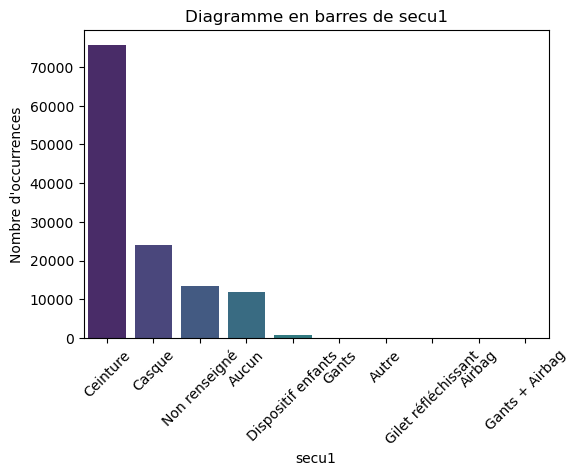

Analysons la variable : secu2
--------------------------------------------------
Le nombre de valeurs manquantes de secu2: 0
Le mode de la variable secu2 est : -1
secu2
-1                     52978
Aucun                  46080
Gants                  11651
Non renseigné          11439
Airbag                  1529
Gilet réfléchissant     1381
Autre                    350
Ceinture                 247
Dispositif enfants       149
Gants + Airbag           145
Casque                   124
Name: count, dtype: int64


C:\Users\SCD UM\AppData\Local\Temp\ipykernel_14508\1584820988.py:40: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=df[col], order=df[col].value_counts().index, palette="viridis")


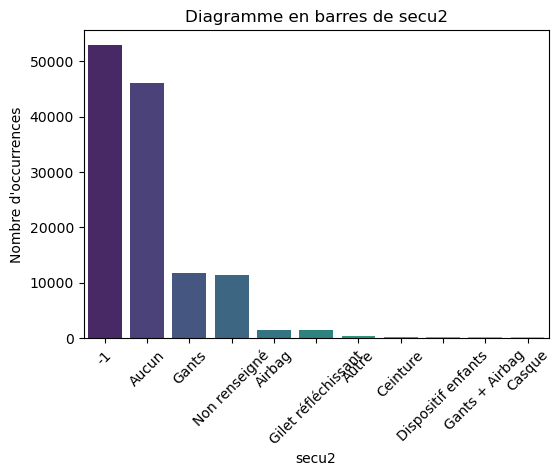

Analysons la variable : secu3
--------------------------------------------------
Le nombre de valeurs manquantes de secu3: 0
Le mode de la variable secu3 est : -1
secu3
-1                     124760
Autre                     908
Aucun                     271
Gants                      78
Non renseigné              27
Gilet réfléchissant        16
Airbag                      5
Gants + Airbag              5
Casque                      3
Name: count, dtype: int64


C:\Users\SCD UM\AppData\Local\Temp\ipykernel_14508\1584820988.py:40: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=df[col], order=df[col].value_counts().index, palette="viridis")


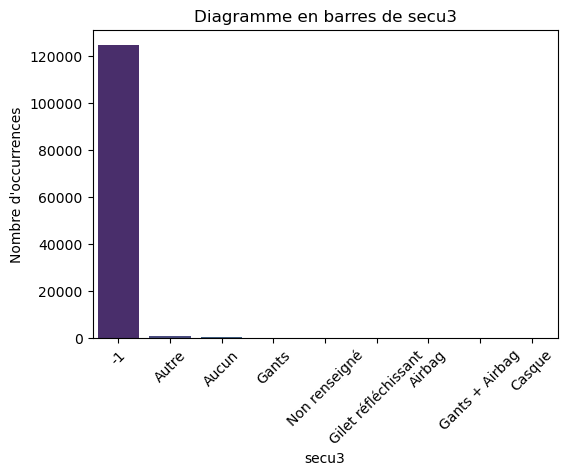

Analysons la variable : locp
--------------------------------------------------
Le nombre de valeurs manquantes de locp: 0
Le mode de la variable locp est : -1
locp
-1                    61576
Aucun                 55215
sur chaussée           3466
Divers                 2979
Sur passage piéton     2837
Name: count, dtype: int64


C:\Users\SCD UM\AppData\Local\Temp\ipykernel_14508\1584820988.py:40: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=df[col], order=df[col].value_counts().index, palette="viridis")


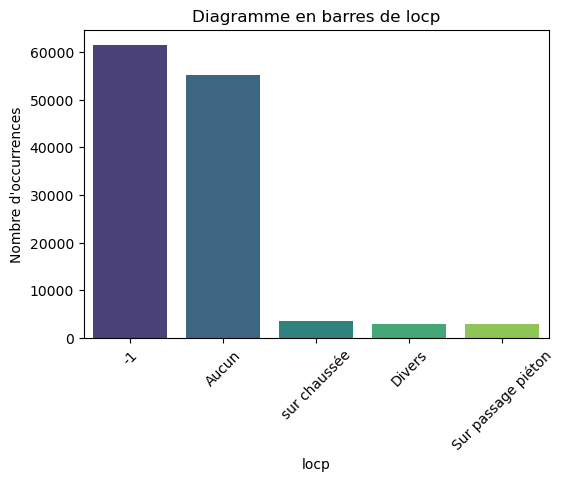

Analysons la variable : actp
--------------------------------------------------
Le nombre de valeurs manquantes de actp: 0
Le mode de la variable actp est : -1
actp
-1                        60085
0                         56674
3                          6831
9                           641
1                           610
5                           434
2                           263
Inconnue                    244
Monte/descend véhicule      120
4                           116
6                            26
8                            19
7                            10
Name: count, dtype: int64


C:\Users\SCD UM\AppData\Local\Temp\ipykernel_14508\1584820988.py:40: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=df[col], order=df[col].value_counts().index, palette="viridis")


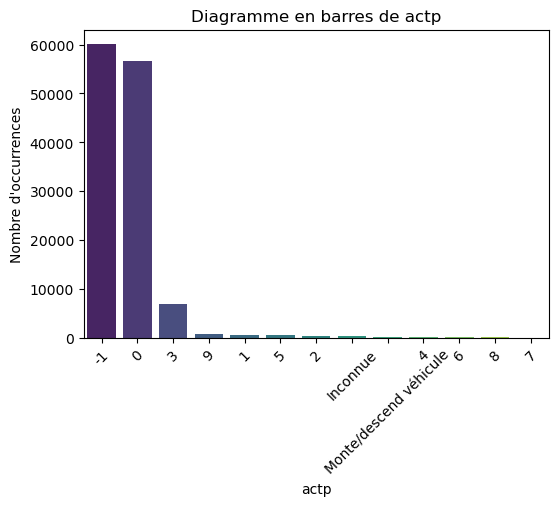

Analysons la variable : etatp
--------------------------------------------------
Le nombre de valeurs manquantes de etatp: 0
Le mode de la variable etatp est : -1
etatp
-1            116773
Seul            7010
Accompagné      1866
En groupe        424
Name: count, dtype: int64


C:\Users\SCD UM\AppData\Local\Temp\ipykernel_14508\1584820988.py:40: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=df[col], order=df[col].value_counts().index, palette="viridis")


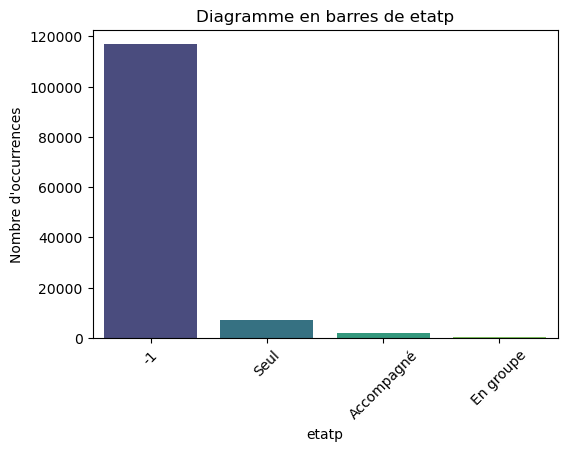

Analysons la variable : senc
--------------------------------------------------
Le nombre de valeurs manquantes de senc: 0
Le mode de la variable senc est : 1
senc
1        57525
2        42911
3        17908
Aucun     7729
Name: count, dtype: int64


C:\Users\SCD UM\AppData\Local\Temp\ipykernel_14508\1584820988.py:40: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=df[col], order=df[col].value_counts().index, palette="viridis")


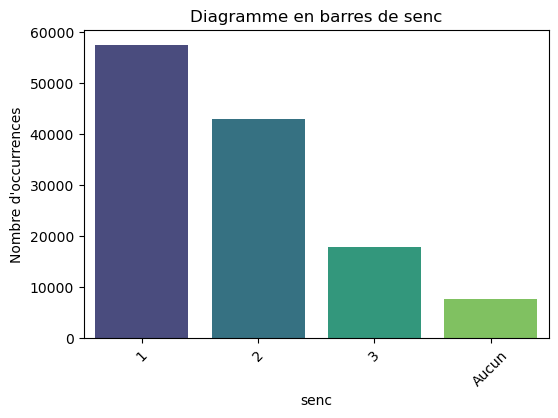

Analysons la variable : catv
--------------------------------------------------
Le nombre de valeurs manquantes de catv: 0
Le mode de la variable catv est : Véhicules légers
catv
Véhicules légers                        81081
Deux-roues motorisés                    19221
Véhicules légers pro                     8529
Deux-roues non motorisés                 6476
Véhicules professionnels spécialisés     3345
Poids lourds                             3028
Véhicules agricoles / spéciaux           2127
Transport en commun                      1604
Autre                                     526
Aucun                                     136
Name: count, dtype: int64


C:\Users\SCD UM\AppData\Local\Temp\ipykernel_14508\1584820988.py:40: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=df[col], order=df[col].value_counts().index, palette="viridis")


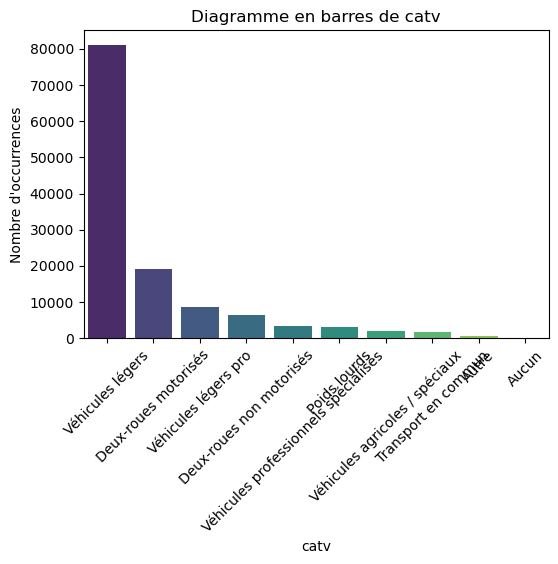

Analysons la variable : obs
--------------------------------------------------
Le nombre de valeurs manquantes de obs: 0
Le mode de la variable obs est : Aucun
obs
Aucun    106257
1          3047
13         2476
2          2229
4          1915
3          1756
8          1683
6          1617
12          983
14          908
15          825
9           726
16          550
7           392
5           237
11          210
10          148
17          114
Name: count, dtype: int64


C:\Users\SCD UM\AppData\Local\Temp\ipykernel_14508\1584820988.py:40: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=df[col], order=df[col].value_counts().index, palette="viridis")


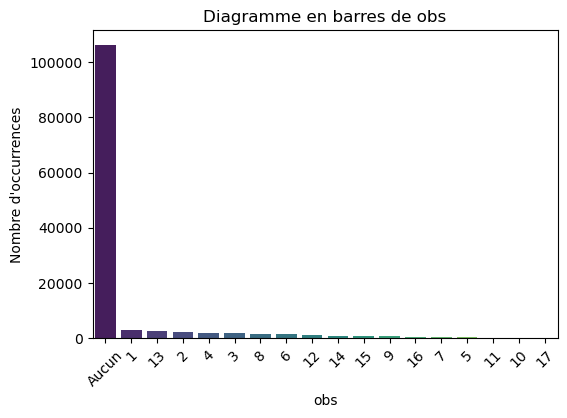

Analysons la variable : obsm
--------------------------------------------------
Le nombre de valeurs manquantes de obsm: 0
Le mode de la variable obsm est : 2
obsm
2        82554
Aucun    23790
1        17397
9         1899
6          181
4          137
5          115
Name: count, dtype: int64


C:\Users\SCD UM\AppData\Local\Temp\ipykernel_14508\1584820988.py:40: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=df[col], order=df[col].value_counts().index, palette="viridis")


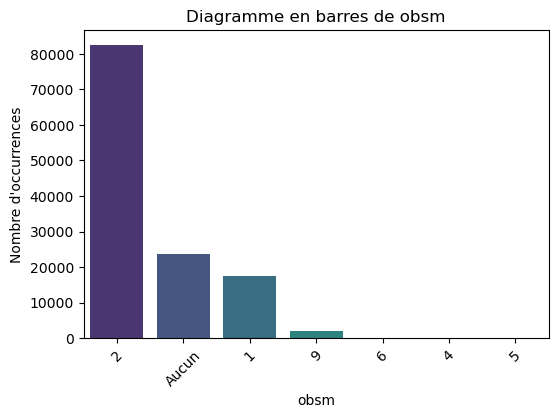

Analysons la variable : choc
--------------------------------------------------
Le nombre de valeurs manquantes de choc: 0
Le mode de la variable choc est : Avant
choc
Avant        45620
Latéral      18772
Arrière      16489
Multichoc    12796
8             8204
7             7259
Aucun         7072
6             4426
Autre         3430
9             2005
Name: count, dtype: int64


C:\Users\SCD UM\AppData\Local\Temp\ipykernel_14508\1584820988.py:40: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=df[col], order=df[col].value_counts().index, palette="viridis")


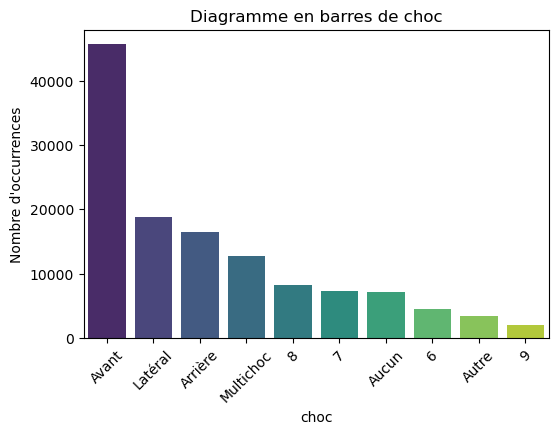

Analysons la variable : manv
--------------------------------------------------
Le nombre de valeurs manquantes de manv: 0
Le mode de la variable manv est : Circulation normale
manv
Circulation normale          68552
Changement de voie           23720
Manœuvre complexe            13978
Aucun                         6621
Autre                         4827
Stationnement/Arrêt           4009
Évitement                     2070
Stationnement                  809
Marche arrière                 717
Ouverture de porte             409
Dans le couloir du bus/MS      316
Dans le couloir du bus/SI       45
Name: count, dtype: int64


C:\Users\SCD UM\AppData\Local\Temp\ipykernel_14508\1584820988.py:40: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=df[col], order=df[col].value_counts().index, palette="viridis")


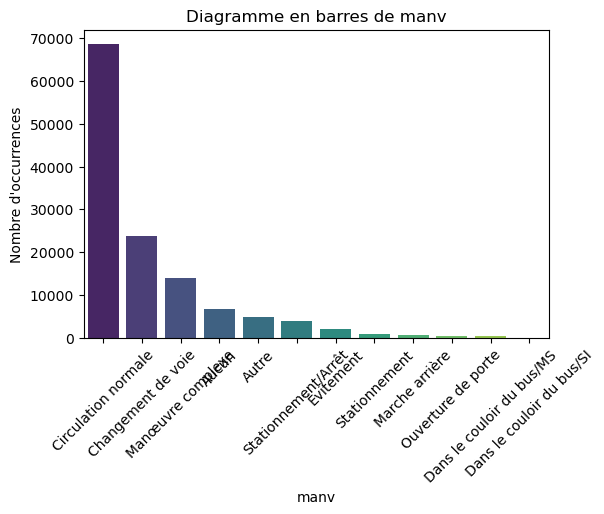

Analysons la variable : motor
--------------------------------------------------
Le nombre de valeurs manquantes de motor: 0
Le mode de la variable motor est : 1
motor
1        109348
5          5466
Aucun      4364
3          3846
2          2471
6           543
4            35
Name: count, dtype: int64


C:\Users\SCD UM\AppData\Local\Temp\ipykernel_14508\1584820988.py:40: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=df[col], order=df[col].value_counts().index, palette="viridis")


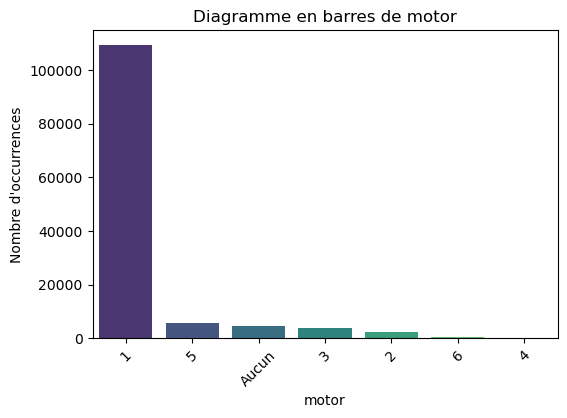

Analysons la variable : occutc
--------------------------------------------------
Le nombre de valeurs manquantes de occutc: 124732
Le mode de la variable occutc est : 1.0
occutc
1.0      687
2.0      178
3.0      147
4.0       87
5.0       40
6.0       28
14.0      27
11.0      22
10.0      18
28.0      17
8.0       16
17.0      16
7.0       14
16.0      14
12.0      12
9.0        9
13.0       8
Aucun      1
Name: count, dtype: int64


C:\Users\SCD UM\AppData\Local\Temp\ipykernel_14508\1584820988.py:40: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=df[col], order=df[col].value_counts().index, palette="viridis")


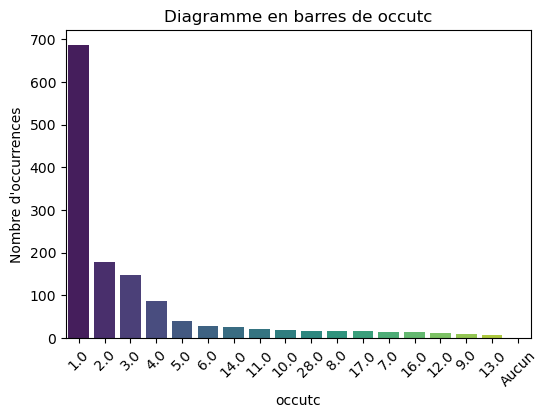

Analysons la variable : jour
--------------------------------------------------
Le nombre de valeurs manquantes de jour: 3
Le mode de la variable jour est : 27.0
count    126070.000000
mean         15.783985
std           8.792682
min           1.000000
25%           8.000000
50%          16.000000
75%          23.000000
max          31.000000
Name: jour, dtype: float64


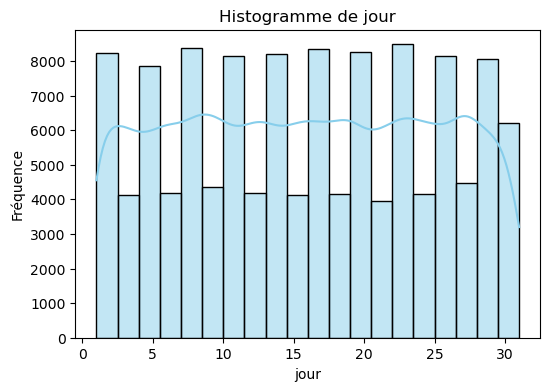

Analysons la variable : mois
--------------------------------------------------
Le nombre de valeurs manquantes de mois: 3
Le mode de la variable mois est : 6.0
count    126070.000000
mean          6.896193
std           3.286779
min           1.000000
25%           4.000000
50%           7.000000
75%          10.000000
max          12.000000
Name: mois, dtype: float64


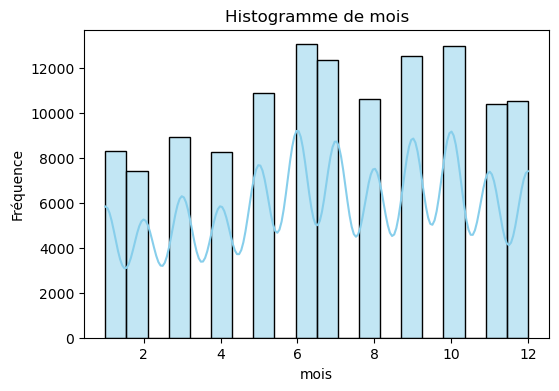

Analysons la variable : lum
--------------------------------------------------
Le nombre de valeurs manquantes de lum: 3
Le mode de la variable lum est : Plein jour
lum
Plein jour                    87999
Nuit éclairage allumé         17467
Nuit sans éclairage public    11416
Crépuscule ou aube             8215
Nuit éclairage non allumé       973
Name: count, dtype: int64


C:\Users\SCD UM\AppData\Local\Temp\ipykernel_14508\1584820988.py:40: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=df[col], order=df[col].value_counts().index, palette="viridis")


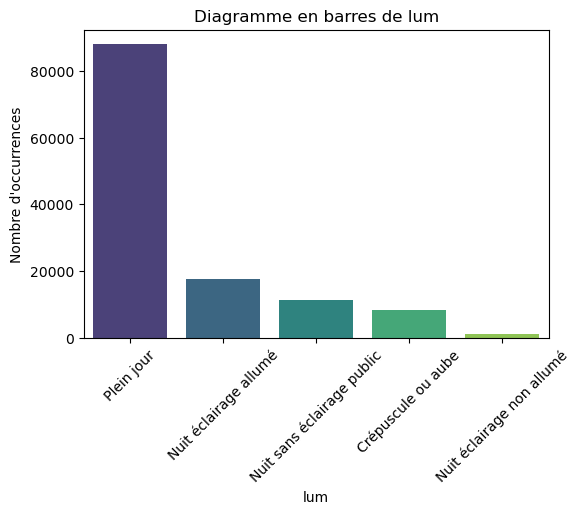

Analysons la variable : com
--------------------------------------------------
Le nombre de valeurs manquantes de com: 0
Le mode de la variable com est : 75116
com
75116    1121
75112     968
97302     853
75119     797
35238     782
         ... 
70357       1
55352       1
65035       1
88258       1
10296       1
Name: count, Length: 11150, dtype: int64


C:\Users\SCD UM\AppData\Local\Temp\ipykernel_14508\1584820988.py:40: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=df[col], order=df[col].value_counts().index, palette="viridis")


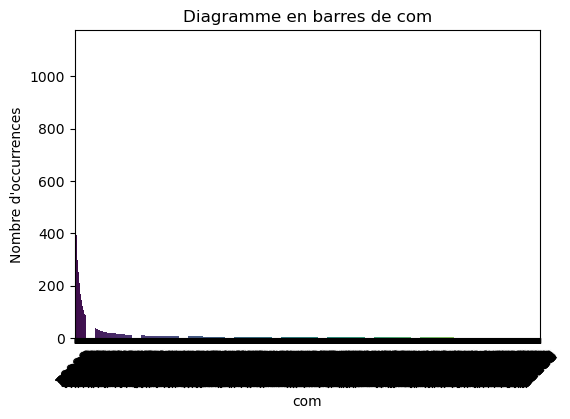

Analysons la variable : agg
--------------------------------------------------
Le nombre de valeurs manquantes de agg: 3
Le mode de la variable agg est : 2.0
count    126070.000000
mean          1.620623
std           0.485234
min           1.000000
25%           1.000000
50%           2.000000
75%           2.000000
max           2.000000
Name: agg, dtype: float64


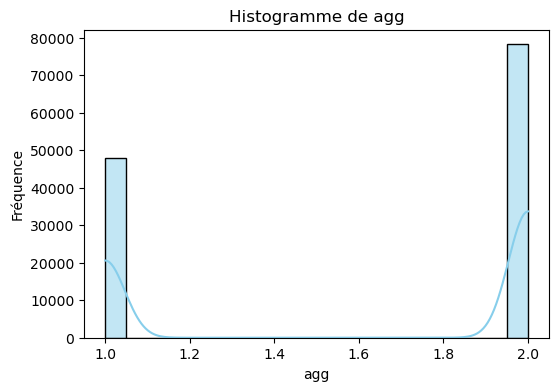

Analysons la variable : int
--------------------------------------------------
Le nombre de valeurs manquantes de int: 3
Le mode de la variable int est : 1.0
count    126070.000000
mean          2.072603
std           2.006574
min           1.000000
25%           1.000000
50%           1.000000
75%           2.000000
max           9.000000
Name: int, dtype: float64


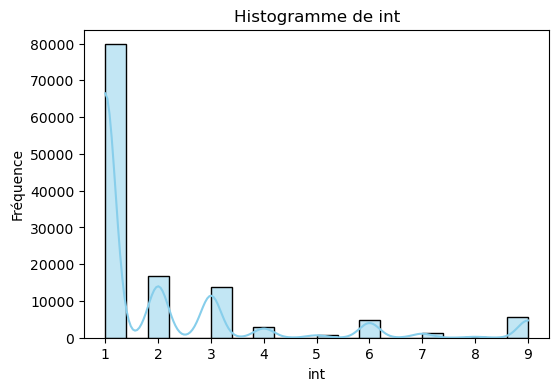

Analysons la variable : atm
--------------------------------------------------
Le nombre de valeurs manquantes de atm: 3
Le mode de la variable atm est : Normale
atm
Normale              100485
Pluie légère          13372
Temps couvert          4945
Pluie forte            2608
Éblouissement          2256
Brouillard/fumée        884
Autre                   636
Neige/grêle             631
Vent fort/tempête       253
Name: count, dtype: int64


C:\Users\SCD UM\AppData\Local\Temp\ipykernel_14508\1584820988.py:40: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=df[col], order=df[col].value_counts().index, palette="viridis")


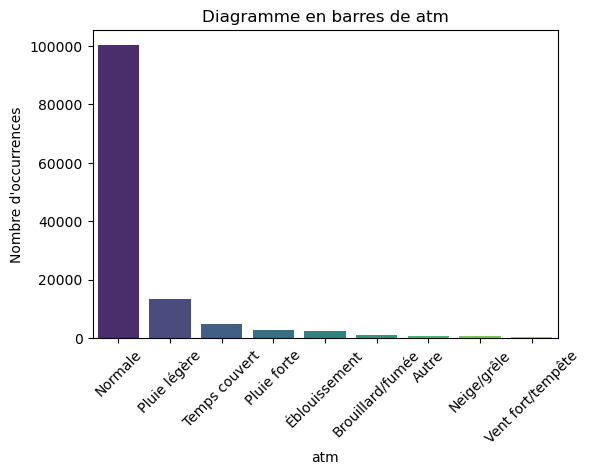

Analysons la variable : col
--------------------------------------------------
Le nombre de valeurs manquantes de col: 3
Le mode de la variable col est : 3.0
count    126070.000000
mean          3.746776
std           1.847771
min           1.000000
25%           2.000000
50%           3.000000
75%           6.000000
max           7.000000
Name: col, dtype: float64


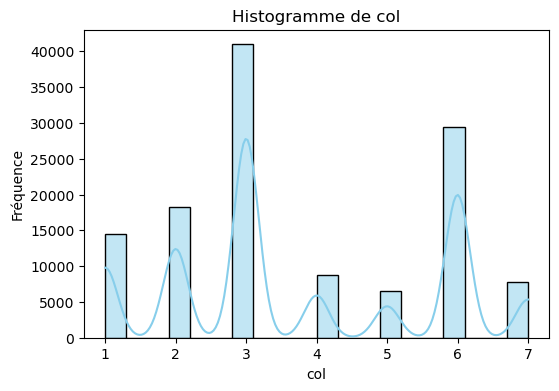

Analysons la variable : adr
--------------------------------------------------
Le nombre de valeurs manquantes de adr: 1358
Le mode de la variable adr est : AUTOROUTE A86
adr
AUTOROUTE A86                 811
AUTOROUTE A1                  668
A4                            655
A13                           623
AUTOROUTE A6                  572
                             ... 
Avenue Edouard Bourlaux         1
767 Route de Saint-Jeannet      1
La Grande Clavelie              1
RUE DE L'HUREPOIX               1
RUE BASTE                       1
Name: count, Length: 29667, dtype: int64


C:\Users\SCD UM\AppData\Local\Temp\ipykernel_14508\1584820988.py:40: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=df[col], order=df[col].value_counts().index, palette="viridis")


In [ ]:
analyse_univ(base_f)

In [163]:
def analyse_multivariee(df):
    # Variables quantitatives
    quanti_cols = [col for col in df.columns if pd.api.types.is_numeric_dtype(df[col])]

    if len(quanti_cols) > 1:
        print("Analyse des variables quantitatives:")
        
        # Matrice de corrélation
        correlation_matrix = df[quanti_cols].corr(method='spearman')
        print("Matrice de corrélation :")
        print(correlation_matrix)

        plt.figure(figsize=(18, 15))
        sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f")
        plt.title("Matrice de corrélation (Heatmap)")
        plt.show()

    else:
        print("Pas assez de variables quantitatives pour effectuer une matrice de corrélation.")

    # Variables qualitatives
    quali_cols = [col for col in df.columns if pd.api.types.is_categorical_dtype(df[col]) or df[col].dtype == 'object']

    if len(quali_cols) > 1:
        print("Analyse des variables qualitatives :")
        for i, col1 in enumerate(quali_cols):
            for col2 in quali_cols[i+1:]:
                print(f"Tableau croisé entre {col1} et {col2} :")
                crosstab = pd.crosstab(df[col1], df[col2])
                print(crosstab)

                # Remplacer la heatmap par un diagramme en barres empilées
                crosstab.plot(kind='bar', stacked=True, figsize=(10,7))
                plt.title(f"Diagramme en barres empilées entre {col1} et {col2}")
                plt.xlabel(col1)
                plt.ylabel("Nombre d'observations")
                plt.legend(title=col2)
                plt.grid(True)
                plt.show()
    else:
        print("Pas assez de variables qualitatives pour effectuer une analyse croisée.")


In [164]:
#analyse_multivariee(base_f)